In [8]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.interpolate import UnivariateSpline
%matplotlib inline

In [9]:
df = pd.read_csv("../data/Bone Mineral Density.txt", sep='\t')
df.head()

,idnum,age,gender,spnbmd
0,1,11.70,male,0.018081
1,1,12.70,male,0.060109
2,1,13.75,male,0.005858
3,2,13.25,male,0.010264
4,2,14.30,male,0.210526


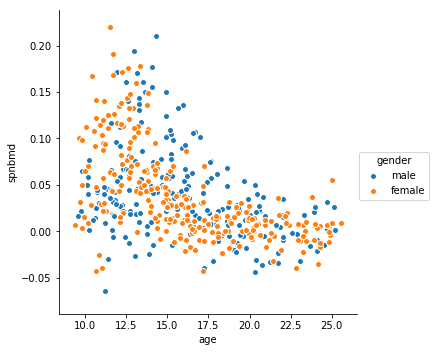

In [10]:
sns.pairplot(x_vars=['age'], y_vars=['spnbmd'], data=df, hue="gender", size=5)

In [32]:
x = np.linspace(df.age.min(), df.age.max(), 100)
x_male = df[df.gender == 'male'].age.values
x_female = df[df.gender == 'female'].age.values
y_male = df[df.gender == 'male'].spnbmd.values
y_female = df[df.gender == 'female'].spnbmd.values

In [39]:
s_male = UnivariateSpline(x_male, list(y_male), k=5)
s_female = UnivariateSpline(x_female, list(y_female), k=5)

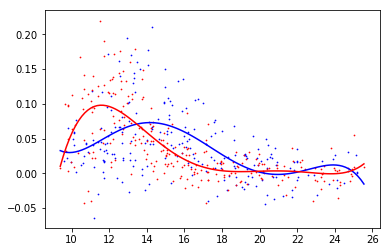

In [40]:
plt.plot(x, s_male(x), color='blue')
plt.plot(x, s_female(x), color='red')
plt.scatter(x_male, y_male, color='blue', s=0.5)
plt.scatter(x_female, y_female, color='red', s=0.5)